In [7]:
#this script only keeps what is essential to finding common walls
# import polyscope as ps
import json
import numpy as np
import pyvista as pv
import math
import os
from helpers.geometry import surface_normal, project_2d, axes_of_normal
from shapely.geometry import MultiPolygon, Polygon
import scipy
from sklearn.cluster import AgglomerativeClustering
import rtree.index
import cityjson
import matplotlib.pyplot as plt

class Vertex():
    def __init__(self, vid, x, y, z):
        self.vid = int(vid)
        self.x = float(x)
        self.y = float(y)
        self.z = float(z)
        
class Face():
    def __init__(self, fid, v_indices):
        self.fid = int(fid)
        self.v_indices = list(v_indices)
        
class Building():
    def __init__(self, bid, faces, vertices):
        self.bid = int(bid)
        self.faces = list(faces)
        self.vertices = list(vertices)


#compute surface normal (might be useful)
def surface_normal(poly):
    n = [0.0, 0.0, 0.0]

    for i, v_curr in enumerate(poly):
        v_next = poly[(i+1) % len(poly)]
        n[0] += (v_curr[1] - v_next[1]) * (v_curr[2] + v_next[2])
        n[1] += (v_curr[2] - v_next[2]) * (v_curr[0] + v_next[0])
        n[2] += (v_curr[0] - v_next[0]) * (v_curr[1] + v_next[1])
    
        if all([c == 0 for c in n]):
            raise ValueError("No normal. Possible colinear points!")

    normalised = [i/np.linalg.norm(n) for i in n]

    return normalised


def is_on_plane(point, normal, origin):
    a, b, c, d = get_plane_params(normal, origin)
    
    x, y, z = point
    
    return a * x + b * y + c * z + d == 0


def plane_params(normal, origin, rounding=2, absolute=True):
    """Returns the params (a, b, c, d) of the plane equation"""
    a, b, c = np.round_(normal, 3)
    x0, y0, z0 = origin
    
    d = -(a * x0 + b * y0 + c * z0)
    
    if rounding >= 0:
        d = round(d, rounding)
    
    return np.array([a, b, c, d])


def face_planes(mesh):
    return [plane_params(mesh.face_normals[i], mesh.cell_points(i)[0]) for i in range(mesh.n_cells)]


def project_mesh(mesh, normal, origin):
    p = []
    for i in range(mesh.n_cells):
        pts = mesh.cell_points(i)
        
        pts_2d = project_2d(pts, normal, origin)
        
        p.append(Polygon(pts_2d))
    
    return MultiPolygon(p).buffer(0)


def to_3d(polygon, normal, origin):
    xa, ya = axes_of_normal(normal)

    mat = np.array([xa, ya])
    pts = np.array(polygon.boundary.coords)

    return np.dot(pts, mat) + origin


def cluster_faces(data, threshold=0.1):
    ndata = np.array(data)
    
    dm1 = scipy.spatial.distance_matrix(ndata, ndata)
    dm2 = scipy.spatial.distance_matrix(ndata, -ndata)

    distance_matrix = np.minimum(dm1, dm2)

    clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=threshold, affinity='precomputed', linkage='average').fit(distance_matrix)
    
    return clustering.labels_, clustering.n_clusters_


def cluster_meshes(meshes, threshold=0.1):
    """Clusters the faces of the given meshes"""
    
    n_meshes = len(meshes)
    
    # Compute the "absolute" plane params for every face of the two meshes
    # list containing sublist for each mesh (each sublist containing one array for parameters of each plane)
    planes = [face_planes(mesh) for mesh in meshes]
    mesh_ids = [[m for _ in range(meshes[m].n_cells)] for m in range(n_meshes)]
    
    # Find the common planes between the two meshes
    # array of parameters for all planes in both meshes (combined)
    all_planes = np.concatenate(planes)
    all_labels, n_clusters = cluster_faces(all_planes, threshold)
    areas = []
    

    # list of arrays (one for each mesh) indicating cluster labels for each face
    labels = np.array_split(all_labels, [meshes[m].n_cells for m in range(n_meshes - 1)])
    
    return labels, n_clusters


def symmetric_difference(meshes):
    """Return the intersection between the surfaces of multiple meshes"""
    
    n_meshes = len(meshes)
    
    areas_inter = []
    areas_symdif = []
    polys_1b = []
    polys_2b = []

    # labels = ndarray of cluster labels associated with each face, n_clusters = integer [number of clusters]
    labels, n_clusters = cluster_meshes(meshes)

    all_idxs = [[],[]]
    # for every cluster
    for plane in range(n_clusters):
        # For every mesh, extract the index of the faces that belong to this cluster
        # idxs is a list of sublists (one for each mesh) containing face indices
        idxs = [[i for i, p in enumerate(labels[m]) if p == plane] for m in range(n_meshes)]
                       

        # check to ensure that both meshes have at least one face that belongs to this cluster
        if any([len(idx) == 0 for idx in idxs]):
            continue         
        
        # take surfaces from each mesh that belong to this cluster, and put them in a polydata object
        msurfaces = [mesh.extract_cells(idxs[i]).extract_surface() for i, mesh in enumerate(meshes)]
                
        # Set the normal and origin point for a plane to project the faces
        origin = msurfaces[0].clean().points[0]
        # get the normal of the first face of the first mesh
        normal = msurfaces[0].face_normals[0]
        
        # Create the two 2D polygons by projecting the faces
        
        polys = [project_mesh(msurface, normal, origin) for msurface in msurfaces]

        # Intersect the 2D polygons
        inter = polys[0]
        for i in range(1, len(polys)):
            inter = inter.intersection(polys[i])
        
        if inter.area > 0.001:
                    
            # creates list of polygons and multipolygons (one for each mesh)
            polys_1b.append(polys[0])
            polys_2b.append(polys[1])
            
            all_idxs[0] = all_idxs[0] + idxs[0]
            all_idxs[1] = all_idxs[1] + idxs[1]  
                                               

    # """All intersections"""
    # loop in polys1b,2b and create the union in each, and then intersect the two.
    union_1b = polys_1b[0]
    for i in range(1, len(polys_1b)):
        union_1b = union_1b.union(polys_1b[i])
        
    union_2b = polys_2b[0]
    for i in range(1, len(polys_2b)):
        union_2b = union_2b.union(polys_2b[i])
        
    inter = union_2b.intersection(union_1b)    
    symdif = union_2b.symmetric_difference(union_1b)
    
    
    # Set the normal and origin point for a plane to project the faces
    origin = meshes[0].extract_cells(all_idxs[0][0]).extract_surface().clean().points[0]
    # get the normal of the first face of the first mesh
    normal = meshes[0].extract_cells(all_idxs[0][0]).extract_surface().face_normals[0]
                
    if inter.area > 0.001:        
    
        if inter.type == "MultiPolygon":            
            #  project back to 3D
            for geom in inter.geoms:
                # print("Is Geometry Valid?: ", geom.is_valid)                    
                pts = to_3d(geom, normal, origin)                    
                common_mesh_inter = pv.PolyData(pts, faces=[len(pts)] + list(range(len(pts)))) 
                common_mesh_inter["area"] = [geom.area]
                areas_inter.append(common_mesh_inter)
                
        if inter.type == "Polygon":
                pts = to_3d(inter, normal, origin)
                common_mesh_inter = pv.PolyData(pts, faces=[len(pts)] + list(range(len(pts))))
                common_mesh_inter["area"] = [inter.area]
                areas_inter.append(common_mesh_inter)
    
    if symdif.area > 0.001:
        
        if symdif.type == "MultiPolygon":
            for geom in symdif.geoms:                  
                pts = to_3d(geom, normal, origin)                    
                common_mesh_symdif = pv.PolyData(pts, faces=[len(pts)] + list(range(len(pts)))) 
                common_mesh_symdif["area"] = [symdif.area]
                areas_symdif.append(common_mesh_symdif)
                
        if symdif.type == "Polygon":
            pts = to_3d(inter, normal, origin)
            common_mesh_symdif = pv.PolyData(pts, faces=[len(pts)] + list(range(len(pts))))
            common_mesh_symdif["area"] = [symdif.area]
            areas_symdif.append(common_mesh_symdif)


    return all_idxs, areas_inter, areas_symdif


def intersect_pairs(mesh, neighbours):
    # can call this function to get common walls between one mesh and many others
    return np.hstack([intersect_surfaces([mesh, neighbour]) for neighbour in neighbours])


def get_bbox(geom, verts):
    pts = np.array(cityjson.get_points(geom, verts))

    return np.hstack([[np.min(pts[:, i]), np.max(pts[:, i])] for i in range(np.shape(pts)[1])])


def generator_function(cm, verts):
    for i, objid in enumerate(cm["CityObjects"]):
        obj = cm["CityObjects"][objid]
        xmin, xmax, ymin, ymax, zmin, zmax = get_bbox(obj["geometry"][0], verts)
        yield (i, (xmin, ymin, zmin, xmax, ymax, zmax), objid)


def rpath(path):
    return os.path.expanduser(path)


def plot_meshes(meshes, **kargs):
    p = pv.Plotter(**kargs)

    p.add_mesh(meshes[0], color="red")
    for mesh in meshes[1:]:
        p.add_mesh(mesh)

    p.show()


def distance(x, y):
    """Returns the euclidean distance between two points"""

    return math.sqrt(sum([math.pow(x[c] - y[c], 2) for c in range(len(x))]))


def abs_distance(x, y):
    """Returns the minimum absolute distance"""

    return min(distance(x, y), distance(x, [-e for e in y]))


ModuleNotFoundError: No module named 'ipyvtk'

In [3]:

# Implementation

# Load cityjson
float_formatter = "{:.3f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

filename = "two_buildings_5097.json"

with open(filename) as file:
    cm = json.load(file)

if "transform" in cm:
    s = cm["transform"]["scale"]
    t = cm["transform"]["translate"]
    verts = [[v[0] * s[0] + t[0], v[1] * s[1] + t[1], v[2] * s[2] + t[2]]
            for v in cm["vertices"]]
else:
    verts = cm["vertices"]

# mesh points
vertices = np.array(verts)

# create a dictionary with the index as key and the coords as values
verts_dict = {}
for i, vert in enumerate(vertices):
    verts_dict[i] = [vert[0], vert[1], vert[2]]


# what is this?
p = rtree.index.Property()
p.dimension = 3
r = rtree.index.Index(generator_function(cm, vertices), properties=p)


NL.IMBAG.Pand.0503100000013091-0
[23, 24, 25, 39, 40, 41, 42, 56, 57, 58, 59, 66, 67, 68, 69, 70]


/Users/fabzv/miniconda3/envs/synth/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(


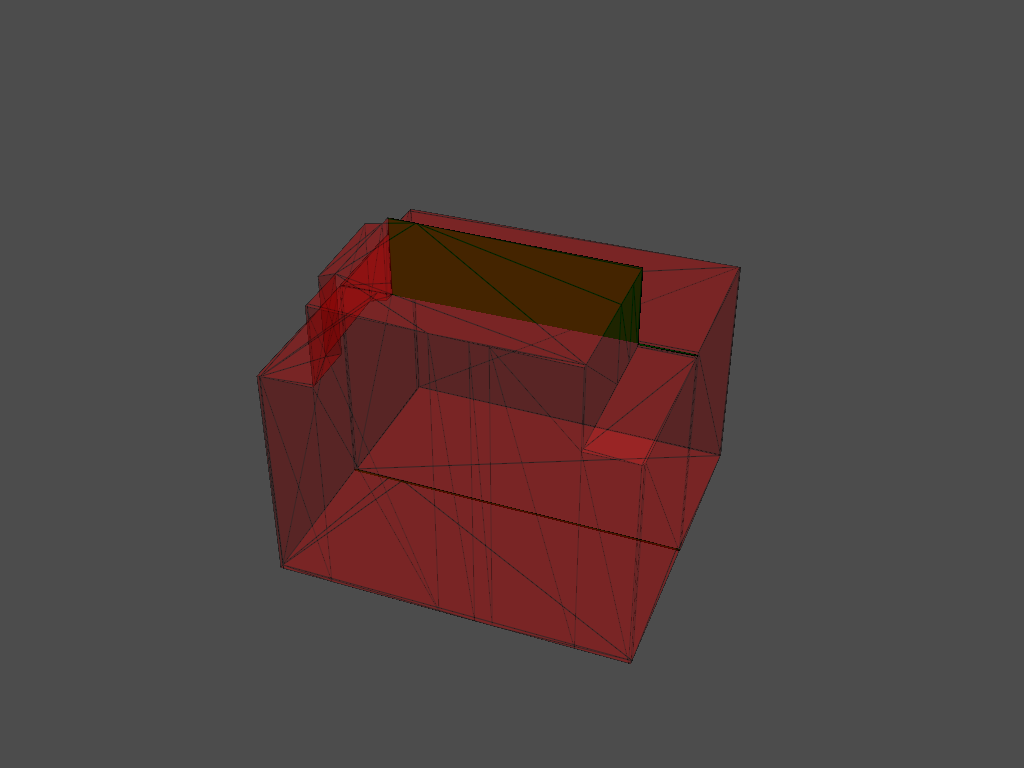

NL.IMBAG.Pand.0503100000031840-0
[22, 23, 28, 29, 32, 33]


/Users/fabzv/miniconda3/envs/synth/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(


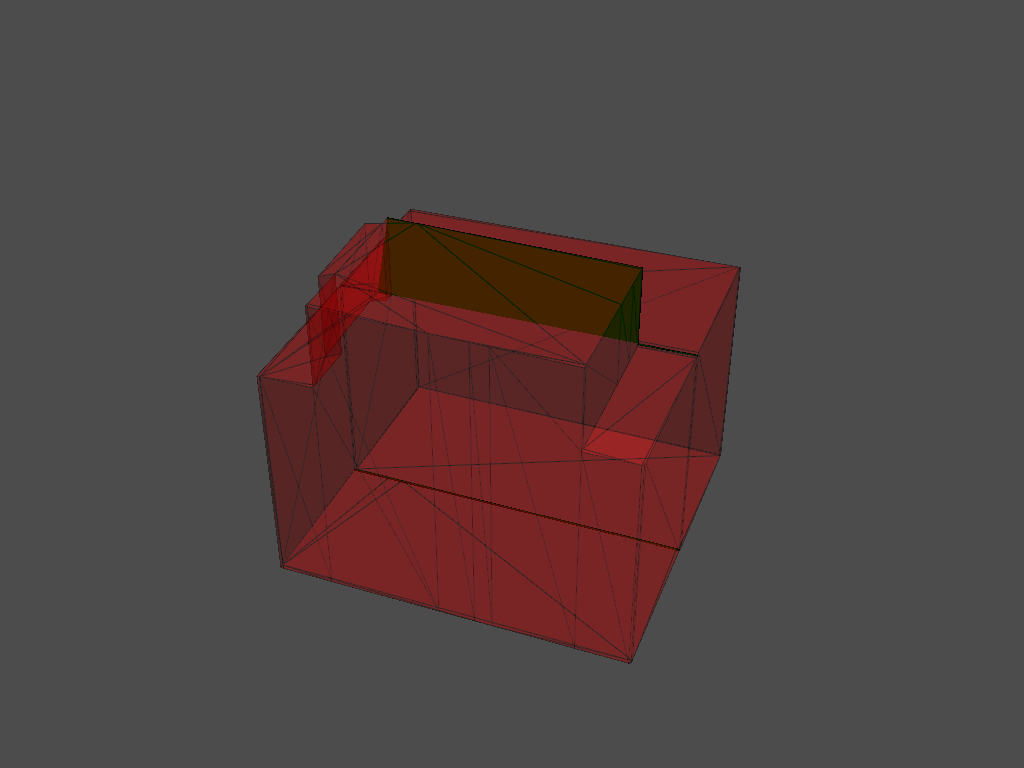

'create polydata'

In [5]:

# MULTIPLE BUILDING VERSION
clustered_buildings = {}


for building_part in cm['CityObjects']:           
                
    if '-' in building_part:     
        print(building_part)
        
        """ ACCESSing CityJson data model *** NOT TRIANGULATED """ # --> no need to access 
        
        xmin, xmax, ymin, ymax, zmin, zmax = get_bbox(cm["CityObjects"][building_part]["geometry"][0], verts)
        objids = [n.object for n in r.intersection((xmin, ymin, zmin, xmax, ymax, zmax), objects=True) if n.object != building_part]
        # this is the name of each building 

        # POLYDATA object (TRIANGULATED)
        main_mesh = cityjson.to_triangulated_polydata(cm["CityObjects"][building_part]["geometry"][2], vertices).clean()
        # print(main_mesh.n_cells) # 128 faces for the old mesh  
        numf_b1 = main_mesh.n_cells
        
                        
        # print(main_mesh.points)
        
        # meshes = [cityjson.to_triangulated_polydata(cm["CityObjects"][objid]["geometry"][2], vertices).clean() for objid in objids if '-' in objid]
        meshes = []
        meshes_id = []
        for objid in objids:
            if '-' in objid: # and objid in check_list:               
                meshes.append(cityjson.to_triangulated_polydata(cm["CityObjects"][objid]["geometry"][2], vertices).clean())
                meshes_id.append(objid)

        # Make origin of the building mesh at the center (mean) of the points
        t = np.mean(main_mesh.points, axis=0)
        main_mesh.points -= t
        for mesh in meshes:
            mesh.points -= t
            
 
        for nearby_building in range(len(meshes)):
            # print(meshes[nearby_building].n_cells) # 44
            numf_b2 = meshes[nearby_building].n_cells
            
            merged_mesh = main_mesh + meshes[nearby_building]
     
            
            all_idxs, intersection, symdif = symmetric_difference([main_mesh, meshes[nearby_building]])
            
            inter_mesh = intersection[0]
            for i in range(1, len(intersection)):
                inter_mesh = inter_mesh + intersection[i]
                
            symdif_mesh = symdif[0]
            for i in range(1, len(symdif)):
                symdif_mesh = symdif_mesh + symdif[i]
                                                                                                 
                        
            faces1b = []
            faces2b = []
            it = 0
            new_nearby_mesh = meshes[nearby_building]
            new_main_mesh = main_mesh
            new_merged_mesh = merged_mesh
            
            
            faces_to_remove = []
            for idx in all_idxs:                    
                if it==1:
                    faces_1 = [i for i in [i+numf_b1 for i in idx]]
                else:               
                    print(idx)
                    faces_0= [i for i in idx]  
                    new_main_mesh = new_main_mesh.remove_cells(idx)
                # when it's done with the first sublist, increase the it. 
                it = 1 
            
            faces_to_remove = faces_0 + faces_1        
            new_merged_mesh = new_merged_mesh.remove_cells(faces_to_remove)

            # RECONSTRUCTING SURFACE WITH new_merged_mesh.points
            reconstructed_mesh = new_merged_mesh.reconstruct_surface()
            
            
            
            
# #             # plot both buildings
            plotter = pv.Plotter()
            ## add meshes
            actor =  plotter.add_mesh(new_merged_mesh, opacity = 0.3, color = "red", show_edges = True)
            # actor10 =  plotter.add_mesh(reconstructed_mesh, opacity = 0.3, color = "yellow", show_edges = True)
            
            actor1 =  plotter.add_mesh(symdif_mesh, color = "green", show_edges = True)
            # actor2 =  plotter.add_mesh(inter_mesh, color = "blue", show_edges = True)
            ## add points of meshes
            # actor3 = plotter.add_points(symdif_mesh.points, render_points_as_spheres=True, point_size=10.0, color='pink')
            #actor4 = plotter.add_points(inter_mesh.points, render_points_as_spheres=True, point_size=10.0)
            # actor5 = plotter.add_points(new_merged_mesh.points, render_points_as_spheres=True, point_size=10.0, color='yellow')            
            plotter.show()







#             # SECTION: turn the new merged mesh into our own data model
#             # 1. access the vertices, save as class vertices
            
#             building_vertices = []
#             list_building_vertices = []
#             vid = 0
#             for i in new_merged_mesh.points:
#                 building_vertices.append(Vertex(vid, i[0], i[1], i[2]))
#                 list_building_vertices.append([i[0], i[1], i[2]])
#                 vid += 1
            
#             building_tree = scipy.spatial.KDTree(list_building_vertices)
#             inter_sym_vertices = []
#             list_inter_sym_vertices = []
            
#             for i in inter_mesh.points:
#                 inter_sym_vertices.append(Vertex(vid, i[0], i[1], i[2]))
#                 list_inter_sym_vertices.append([i[0], i[1], i[2]])
#                 vid += 1

#             # add vertices of intersection and symdif as new vertices 
#             # (attention: not create duplicate vertices)
#             # create a kdtree only for intersection vertices, request nearest_neighb with symdif 
#             tree = scipy.spatial.KDTree(inter_mesh.points)
            
#             for point in symdif_mesh.points:                
#                 neighbours = tree.query_ball_point(point, 0.01, p=2)
#                 if len(neighbours) > 0:
#                     continue
#                 else:
#                     inter_sym_vertices.append(Vertex(vid+1, point[0], point[1], point[2]))

                    
#             # for every vertex in the intersection/symmetric difference, check if there is 0, 1 or 2 NN
#             for vertex in list_inter_sym_vertices:
#                 neighbours = building_tree.query_ball_point(vertex,0.000001,p=2)
#                 if len(neighbours) == 2:
#                     print("replace both")
#                 if len(neighbours) == 1:
#                     print("replace one and add one")
#                 if len(neighbours) == 0:
#                     print("add to both")
#                 else:
#                     print("the project fails")                    
                
#             # access all faces, save as class faces
#             building_faces = []
#             fid = 0
#             for f in new_merged_mesh.faces.reshape(-1,4):
#                 building_faces.append(Face(fid, [f[1], f[2], f[3]]))
#                 fid += 1
            
#             # create building object 
#             bid = 0
#             merged_building = Building(bid, building_faces, building_vertices)
#             # access --> merged_building.faces[0].v_indices[1]
            
#             # looking for each of the inter_sym vertices, if ... 
            
            
            

            
            
            
            
            
            
            
            
            
                
                
        
    
   


    

        """Multiple Clusters"""
        
#         intersection = symmetric_difference([main_mesh, meshes[nearby_building]])
#         # print(intersection)
#         intersection[0].plot(text=f"Intersection[{i}]")    
        
        
                                                                            
        
            
        """ACCESS PolyData data model."""
        
        # for each triangle-face --> prints the vertices 
#         for i in range(main_mesh.n_cells):
#             print(main_mesh.cell_points(i))         
        # prints a list with sublists of points 
#         print(main_mesh.points)

        
        # prints an array with 4 numbers for each face, 3 0 1 2 --> meaning 3 vertices, the 0, 1, 2
#         print(main_mesh.faces) 
        

#         # prints the number of cells ?  --> 128 (2*66 --> makes sense), 44 (2*22)
#         print(main_mesh.n_cells)
        
                       
    """NOTES"""
                

        # visualize candidate buildings + reference building
        # plot_meshes([main_mesh] + meshes)
        # plot = main_mesh.plot(scalars=cluster_meshes([main_mesh])[0])
        
        # common_meshes = np.array # save here all neighbour meshes 

      
                
#                 # show nearby building that has at lease one shared face
#                 meshes[nearby_building].plot(scalars=cluster_meshes([meshes[nearby_building]])[0], text=f"Nearby building[{nearby_building}]")
#                 # show each of the shared faces individually
#                 for i in range(len(intersection)):
#                     intersection[i].plot(text=f"Intersection[{i}]")
                #intersection.plot(text=f"Intersection[{i}]")

        
"""Plot """                                                          
#             plot_meshes([new_main_mesh] + symdif + intersection)
        
            # plot_meshes(symdif)
#             for i in range(len(symdif)):
#                 symdif[i].plot(text=f"Intersection[{i}]")


"""Plot"""
# #             # plot both buildings
#             plotter = pv.Plotter()
           # actor2 =  plotter.add_mesh(inter_mesh, color = "blue", show_edges = True)
        
         #   actor1 =  plotter.add_mesh(new_main_mesh, color = "yellow", show_edges = True)
           # actor2 =  plotter.add_mesh(meshes[nearby_building], color = "yellow", show_edges = True)
#             actor1 = plotter.add_mesh(mesh_b1, color = "red", show_edges = True)
#             actor2 = plotter.add_mesh(mesh_b2, color = "yellow", show_edges = True)
#             plotter.show()

"""create polydata"""
                                    
#             # create polydata for the first building             
#             faces1b = np.hstack(faces1b)
#             mesh_b1 = pv.PolyData(main_mesh.points, faces1b) 
            
#             # create polydata for the second building             
#             faces2b = np.hstack(faces2b)
#             mesh_b2 = pv.PolyData(meshes[nearby_building].points, faces2b) 

        
        
# with open('merge_buildings.txt', 'w') as f:
#     for i in all_merged_buildings:
#         f.write(";")
#         for j in i:
#             f.write(j+',')

# main_mesh.save("cluster.vtk")


